In [1]:

#

# %%
# cv to optimize hyperparameter K (window len) (in principle we expect an avg len of SP of 22)
# hyperparameters are K, gamma(sd of gaussian kernel) and c
# POSSIBLE FEATURES
# hydrophobicity profile along the SP (sliding window of 5), after we extract only the avg and max hp from the profile; encode also pos in which there is the max value,
# soe cases of SP are enriched of + resdues in the N-terminal

# normalize hp avg and max????
# add also positivily charged max and pos features?

# %%
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from scipy.stats import sem
import seaborn as sns
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.pipeline import make_pipeline
from sklearn.metrics import matthews_corrcoef,precision_score, recall_score,accuracy_score
from Bio.SeqUtils.ProtParam import ProteinAnalysis as pa

def get_modes(df):
    modes = df['K'].mode()
    best_index = 0
    if len(modes) >1:
        diff = (modes[0] - 23)**2
        print(diff)
        for i in range(1,len(modes)):
            if (modes[i]-23)**2 <= diff:
                best_index = i
    best_K = modes[best_index]
    # scale is preferred over other gamma values
    modes = df['gamma'].mode()
    best_gamma = modes[0]
    for mode in modes:
        if mode == 'scale':
            best_gamma = 'scale'
    # lower value of C generalize better
    modes = df['C'].mode()
    best_C = modes[0]
    for i in range(1,len(modes)):
        if modes[i]<best_C:
            best_C = modes[i]
    return(best_K,best_gamma,best_C)

def get_results(df,name_of_model):
    hp_modes = get_modes(df)
    avg = df[['MCC val','MCC test','ACC','precision','recall']].mean()
    se = df[['MCC val','MCC test','ACC','precision','recall']].sem()
    # Create a new DataFrame with the desired format
    result_df = pd.DataFrame({
        'metric': ['MCC val','MCC test','ACC','precision','recall'],
        name_of_model: [f'{avg:.2f} ± ({std:.2f})' for avg, std in zip(avg, se)]})

    #Set the 'metric' column as the index
    result_df.set_index('metric', inplace=True)
    result_df = result_df.transpose()[:][:]
    result_df.columns = ['MCC val','MCC test','ACC','precision','recall']
    result_df.insert(0, 'K', hp_modes[0])
    result_df.insert(1, 'gamma', hp_modes[1])
    result_df.insert(2, 'C', hp_modes[2])
    result_df = result_df.reset_index(names='model')
    return result_df


def encode(df,K,c_comp=False,local_hp=False,local_hp2=False,K2=False,win=False,feature_filter=False):
    #add X = 0 to avoid warning regarding unknown aa
    hp_scale = {
    'A': 1.8, 'R': -4.5, 'N': -3.5, 'D': -3.5, 'C': 2.5,
    'Q': -3.5, 'E': -3.5, 'G': -0.4, 'H': -3.2, 'I': 4.5,
    'L': 3.8, 'K': -3.9, 'M': 1.9, 'F': 2.8, 'P': -1.6,
    'S': -0.8, 'T': -0.7, 'W': -0.9, 'Y': -1.3, 'V': 4.2, 'X':0.0, 'Z': 0.0, 'B': 0,'U':0
}
    alpha_h = {'A': 0.0, 'R': 1.0, 'N': 0.065, 'D': 0.956, 'C': 0.028, 'Q': 0.068, 'E': 0.96, 'G': 0.0, 'H': 0.992, 'I': 0.002, 'L': 0.002, 'K': 0.952, 'M': 0.028, 'F': 0.007, 'P': 0.03, 'S': 0.032, 'T': 0.032, 'W': 0.04, 'Y': 0.031, 'V': 0.002, 'X':0.0, 'Z': 0.0, 'B': 0,'U':0}

    columns = ['A1', 'C1', 'D1', 'E1', 'F1', 'G1', 'H1', 'I1', 'K1', 'L1', 'M1', 'N1', 'P1', 'Q1', 'R1', 'S1', 'T1', 'V1', 'W1', 'Y1']

    # n_term comosition-------------------------------------------------------------------------------------------------------------------
    n_comp = np.empty((0, 20))
    for index,row in df.iterrows():
        seq = pa(row['Sequence'][:K])
        profile = np.array(list(seq.get_amino_acids_percent().values()))
        n_comp = np.vstack((n_comp,profile))
    enc_array = n_comp

    # c_term composition-----------------------------------------------------------------------------------------------------------------
    if c_comp:
        c_comp = np.empty((0, 20))
        for index,row in df.iterrows():
            seq = pa(row['Sequence'][K:])
            profile = np.array(list(seq.get_amino_acids_percent().values()))
            c_comp = np.vstack((c_comp,profile))
        enc_array = np.hstack((enc_array,c_comp))
        columns.extend(['A2', 'C2', 'D2', 'E2', 'F2', 'G2', 'H2', 'I2', 'K2', 'L2', 'M2', 'N2', 'P2', 'Q2', 'R2', 'S2', 'T2', 'V2', 'W2', 'Y2'])
    # local hydrophobicity window(7) from 0 to K -> avg, max and argmax(pos)-----------------------------------------------------------
    if local_hp:
        local_hp = np.empty((0, 3))
        for index,row in df.iterrows():
            profile = pa.protein_scale(pa(row['Sequence'][:K]),param_dict=hp_scale, window=7, edge=1.0)  #7
            features = np.array([np.argmax(profile)/K, np.max(profile),np.average(profile)])
            local_hp = np.vstack((local_hp,features))
        local_hp[:,1] = (local_hp[:,1]+4.5)/9      #normalize
        local_hp[:,2] = (local_hp[:,2]+4.5)/9
        enc_array = np.hstack((enc_array,local_hp))
        columns.extend(['HP max pos','HP max','HP avg'])

    # local hydrophobicity window(12) from 0 to K2 -> avg, max and argmax(pos)

    if local_hp2:
        local_hp2 = np.empty((0, 3))
        for index,row in df.iterrows():
            profile = pa.protein_scale(pa(row['Sequence'][:K2]),param_dict=hp_scale, window=win, edge=1.0)  #12
            features = np.array([np.argmax(profile)/K2, np.max(profile),np.average(profile)])
            local_hp2 = np.vstack((local_hp2,features))
        local_hp2[:,1] = (local_hp2[:,1]+4.5)/9    #normalize
        local_hp2[:,2] = (local_hp2[:,2]+4.5)/9
        enc_array = np.hstack((enc_array,local_hp2))
        columns.extend(['HP2 max pos','HP2 max','HP2 avg'])

    enc_array = pd.DataFrame(enc_array, columns=columns)
    if feature_filter != False:enc_array = enc_array[feature_filter]
    return enc_array


### Dataset preparation


In [2]:

# %%
#! conda install biopython -y
#random forest to perform feature selection
#to search scales by code
#https://www.genome.jp/aaindex/
training= pd.read_table('../stats/training_metadata_parsed.tsv')[['Signal peptide','Sequence']]
training = training.sample(frac=1, random_state=3)
training['class'] = 0
training.loc[training['Signal peptide'].notna(), 'class'] = 1
#split + and - in 2 df
positives = training.loc[training['class'] == 1,][['Sequence','class']]
negatives = training.loc[training['class'] == 0,][['Sequence','class']]
#positives=np.array(positives)
positives = np.array_split(positives,5)
negatives = np.array_split(negatives,5)
#pa.protein_scale(scale_dict, sliding_window_size)


### Permutation importance CV

In [3]:


#feature encoding funtion parameters
model_combination = 'SVM+feature_selection'
c_comp = True
local_hp = False
local_hp2 = True
#K_list = [22]
K = 27
K2=40
win=12
###
col_names = ['run','training','validation','testing','MCC val','MCC test']
cv_results = []
feature_filter_table =[]
perm_results = []
for run in range(5):
    training = pd.concat((positives[(0+run)%5],positives[(1+run)%5],positives[(2+run)%5],negatives[(0+run)%5],negatives[(1+run)%5],negatives[(2+run)%5]),ignore_index=True)
    val = pd.concat((positives[(3+run)%5],negatives[(3+run)%5]),ignore_index=True)
    test = pd.concat((positives[(4+run)%5],negatives[(4+run)%5]),ignore_index=True)
    X_train,Y_train,X_val,Y_val = encode(training,K, c_comp=c_comp, local_hp=local_hp, local_hp2 = local_hp2, K2=K2,win=win), training['class'], encode(val,K,c_comp=c_comp, local_hp=local_hp, local_hp2 = local_hp2, K2=K2,win=win), val['class']

    model= svm.SVC(C=8,gamma=8,kernel='rbf')
    model.fit(X_train, Y_train)
    mcc_val = matthews_corrcoef(Y_val, model.predict(X_val))
    #
    result = permutation_importance(model, X_val, Y_val, n_repeats=20, random_state=0,n_jobs=-1,scoring='matthews_corrcoef')

    sorted_importances_idx = result.importances_mean.argsort()
    importances = pd.DataFrame(result.importances[sorted_importances_idx].T,columns=X_val.columns[sorted_importances_idx],)
    #perm_importances = result.importances_mean
    #perm_std = result.importances_std
    #sorted_idx = perm_importances.argsort()
    #feature_names = X_val.columns



    perm_results.append(importances)
    #feature_filter = feature_names[sorted_idx[-25:]]
    #feature_filter_table.append(feature_filter)
    ##test
    #
    ##
    #X_train,Y_train,X_test,Y_test = encode(training,K,c_comp=c_comp, local_hp=local_hp, local_hp2 = local_hp2, K2=K2,win=win), training['class'], encode(test,K,c_comp=c_comp, local_hp=local_hp, local_hp2 = local_hp2, K2=K2,win=win), test['class']
    ##add a filter
    #X_train, X_test = X_train[feature_filter], X_test[feature_filter]
    ##
    #model = make_pipeline(svm.SVC(C=8, kernel='rbf', gamma=2))
    #model.fit(X_train, Y_train)
    #mcc_features = matthews_corrcoef(Y_test, model.predict(X_test))
    #run_subsets = [run + 1, ((0+run) % 5, (1+run) % 5, (2+run) % 5), (3+run) % 5, (4+run) % 5]
    #run_subsets.append(mcc_val)
    #run_subsets.append(mcc_features)
    #cv_results.append(run_subsets)
    print('RUN '+str(run)+' ENDED---------------')
    #print(run_subsets)


#

RUN 0 ENDED---------------
RUN 1 ENDED---------------
RUN 2 ENDED---------------
RUN 3 ENDED---------------
RUN 4 ENDED---------------


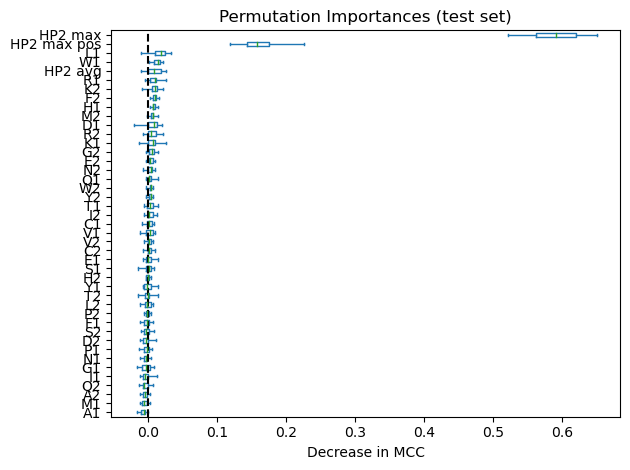

In [4]:

ax = perm_results[4].plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in MCC")
ax.figure.tight_layout()

#### Get for each feature the Avg Rank among the different CV runs.


In [5]:
avg_ranks = {feature: 0 for feature in list(perm_results[0].columns)[::-1]}
for run in range(5):
    col_ranking = perm_results[run].columns[::-1]
    for i in range(len(col_ranking)):
        avg_ranks[col_ranking[i]] += i+1
avg_ranks = pd.DataFrame(list(avg_ranks.items()), columns=['Feature', 'Avg Rank'])
avg_ranks['Avg Rank'] = avg_ranks['Avg Rank']/5
avg_ranks = avg_ranks.sort_values(by='Avg Rank', ascending=True).reset_index(drop=True)
avg_ranks.to_csv('results/avg_ranks.tsv', sep='\t',index=False)
avg_ranks

,Feature,Avg Rank
0,HP2 max,1.0
1,HP2 max pos,2.0
2,L1,3.2
3,HP2 avg,4.0
4,R1,5.8
5,W1,8.6
6,K1,12.6
7,K2,14.0
8,I1,14.6
9,D1,15.6


### CV to optimize k (num. of top features to select)

In [6]:
#feature encoding funtion parameters
model_combination = 'SVM+feature_selection'
c_comp = True
local_hp = False
local_hp2 = True
#K_list = [22]
K = 27
K2=40
win=12
###
col_names = ['run','k','MCC test']
cv_results = []

for run in range(5):
    training = pd.concat((positives[(0+run)%5],positives[(1+run)%5],positives[(2+run)%5],negatives[(0+run)%5],negatives[(1+run)%5],negatives[(2+run)%5]),ignore_index=True)
    #val = pd.concat((positives[(3+run)%5],negatives[(3+run)%5]),ignore_index=True)
    test = pd.concat((positives[(4+run)%5],negatives[(4+run)%5]),ignore_index=True)
    for k in range(10,44):
        feature_filter = list(avg_ranks['Feature'][:k])
        X_train,Y_train= encode(training,K, c_comp=c_comp, local_hp=local_hp, local_hp2 = local_hp2, K2=K2,win=win,feature_filter = feature_filter), training['class']
        model= svm.SVC(C=8,gamma=8,kernel='rbf')
        model.fit(X_train, Y_train)
        X_test,Y_test = encode(test,K,c_comp=c_comp, local_hp=local_hp, local_hp2 = local_hp2, K2=K2,win=win,feature_filter=feature_filter), test['class']
        mcc_test = matthews_corrcoef(Y_test, model.predict(X_test))
        cv_results.append([run + 1,k,mcc_test])
    print('RUN '+str(run)+' ENDED---------------')
#


RUN 0 ENDED---------------
RUN 1 ENDED---------------
RUN 2 ENDED---------------
RUN 3 ENDED---------------
RUN 4 ENDED---------------


In [7]:
cv_results = pd.DataFrame(cv_results,columns=col_names)
cv_results 

,run,k,MCC test
0,1,10,0.864158
1,1,11,0.862674
2,1,12,0.869061
3,1,13,0.866220
4,1,14,0.870482
...,...,...,...
165,5,39,0.893531
166,5,40,0.899676
167,5,41,0.892045
168,5,42,0.895501


In [8]:
avg_mcc = cv_results.groupby('k')['MCC test'].mean()
avg_mcc.to_csv('results/feature ranking MCC vs k.tsv',sep='\t')
avg_mcc

k
10    0.864649
11    0.860205
12    0.865573
13    0.863695
14    0.860839
15    0.867048
16    0.873254
17    0.875730
18    0.879683
19    0.880145
20    0.876960
21    0.879710
22    0.881903
23    0.883095
24    0.890598
25    0.893175
26    0.893884
27    0.895586
28    0.894480
29    0.888909
30    0.888873
31    0.889839
32    0.895421
33    0.891870
34    0.896379
35    0.894125
36    0.897038
37    0.895772
38    0.896578
39    0.894042
40    0.897327
41    0.890480
42    0.892578
43    0.891366
Name: MCC test, dtype: float64

### k = 28 is the smallest k mantaining a stable MCC in respect to no feature selection

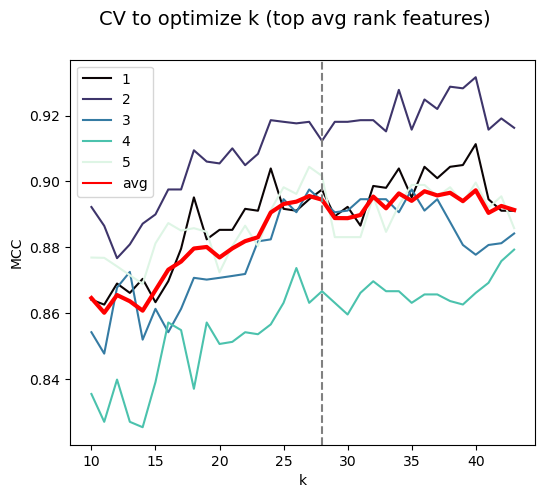

In [9]:

plt.figure(figsize=(6, 5))
plt.suptitle('CV to optimize k (top avg rank features)',size=14)
sns.lineplot(data=cv_results,  x='k', y='MCC test', hue='run',palette='mako')
sns.lineplot(avg_mcc,color='red',linewidth=3).set(xlabel='k',ylabel='MCC')
plt.axvline(x=28, color='grey', linestyle='--')
handles, labels = plt.gca().get_legend_handles_labels()
# Create a custom legend with the 'avg' label and a red line symbol
custom_legend = handles + [plt.Line2D([0], [0], color='red', label='avg', linestyle='-')]
plt.legend(custom_legend, labels + ['avg'])
plt.savefig('figures/feature_selection.svg')

### Top-28 features

In [13]:
avg_mcc
final_feature_filter = list(avg_ranks['Feature'][:27])
final_feature_filter


['HP2 max',
 'HP2 max pos',
 'L1',
 'HP2 avg',
 'R1',
 'W1',
 'K1',
 'K2',
 'I1',
 'D1',
 'S1',
 'E1',
 'I2',
 'G1',
 'C2',
 'M2',
 'R2',
 'L2',
 'G2',
 'Q1',
 'N1',
 'Y2',
 'V1',
 'N2',
 'D2',
 'P1',
 'Y1']